In [1]:
import os, sys, re
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# установка стиля matplotlib
%matplotlib inline
plt.style.use('ggplot')

# доступные стили отображения графика в matplotlib
# plt.style.available

# библиотека иерархической кластеризации (для построения дендрограммы) 
from scipy.cluster import hierarchy

# библиотека для построения выпуклой оболочки множества точек 
from scipy import spatial

# from ydata_profiling import ProfileReport         # отключено пока не "починят"
import sweetviz as sv
import dtale
import statistics as stcs
import statsmodels.stats.proportion as stsmdls

# библиотека для расчетов корреляций
from scipy import stats
from sklearn import metrics

# библиотека для нормализации, стандартизации
from sklearn import preprocessing

# библиотека модели линейной регрессии
from sklearn import linear_model

# библиотека модели деревьев решения
from sklearn import tree

# библиотека модели ансамблей
from sklearn import ensemble

# библиотека модели кластеризации
from sklearn import cluster

# библиотека модели эллиптической кластеризации
from sklearn import mixture

# библиотека модели метода главных компонент PCA
from sklearn import decomposition

# библиотека модели TSNE
from sklearn import manifold

# библиотека clustergram-кластеризации
from clustergram import Clustergram

# библиотека для разделения датасета
from sklearn import model_selection

# библиотека для исключения признаков RFE
from sklearn import feature_selection

# библиотека для кодирования признаков
import category_encoders as ce

# для обработки timestamp в формате utc
import datetime, time

# работа с json
import json
from pprint import pprint

# веб-скрэпинг сайтов
import requests
from bs4 import BeautifulSoup

# выводить все результаты вычислений в ячейках Code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# подключить Latex
from IPython.display import Latex

# загрузка файлов
import wget
import kaggle

# логгирование / логирование
import logging

# скрытие сообщений об ошибках при обработке ответов
import warnings
# игнорируем предупреждения
warnings.filterwarnings('ignore')

# подключение comet_ml
from comet_ml import Experiment

# изменить формат вывода pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.set_option('display.max_info_rows', 500)
# pd.set_option('display.max_info_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.large_repr', 'truncate')

# Предсказание   дохода



Целью данной задачи является построение модели **классификации пользователей**: на вход модель будет принимать данные о человеке, а на выходе она должна предсказывать бинарный уровень дохода человека (больше или меньше 50000$ за год).

## Загрузка библиотек

<img src='https://camo.githubusercontent.com/b35adf34bc440ea2ac19bb0d3432f48e26d71ab8e4c256e936b709eec44f5b19/68747470733a2f2f7777772e636f6d65742e6d6c2f696d616765732f6c6f676f5f636f6d65745f6c696768742e706e67' width=500px>

In [2]:
#!pip install comet_ml

In [3]:
# Необходимые для подключения к API Comet.ML данные содержатся в отдельном файле ~/.comet.config
# для безопасности. Параметры импортируются на основании переменной окружения COMET_CONFIG=%USERPROFILE%\

# проект оформлен как публичный
# https://www.comet.com/best1ll/predict-income/1c74f94bb44a43989e943634d12c4def

# эксперимент с помощью личного API ключа
experiment = Experiment(
    # api_key=,
    project_name='predict-income',
    # workspace=
);

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/best1ll/predict-income/1c74f94bb44a43989e943634d12c4def



## Загрузка данных

In [4]:
%%capture
# выгружаем файл в ./data/, перезаписываем при наличии, выводим сообщения только при ошибке
!wget -q -O ./data/train.csv https://www.dropbox.com/s/1hfrcm09qtvoeoz/train.csv
!wget -q -O ./data/test.csv https://www.dropbox.com/s/jj7c8r0x57zda0a/test.csv

In [5]:
# считываем датасеты
training_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [6]:
training_data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States,0
1,27,NaN,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,45,United-States,0
2,44,NaN,11th,Married-civ-spouse,Other-service,Husband,Black,Male,0.0,0.0,60,United-States,0
3,59,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,0.0,0.0,60,United-States,0
4,54,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,0.0,1408.0,38,United-States,0


Проверим размерности наших файлов:

In [7]:
training_data.shape, test_data.shape

((24420, 13), (8141, 13))

**Работаем с целевой переменной**



In [8]:
target_name = 'income'

In [9]:
y_train = training_data[target_name]
y_test = test_data[target_name]

X_train = training_data.drop(columns=[target_name])
X_test = test_data.drop(columns=[target_name])

**Оценка сбалансированности выборки**

In [10]:
y_train.value_counts(normalize=True)

income
0    0.757821
1    0.242179
Name: proportion, dtype: float64

Таким образом, имеем задачу **несбалансированной бинарной классификации**. 

## Общая статистика по числовым данным



In [11]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,24420.0,38.598116,13.638458,17.0,28.0,37.0,48.0,90.0
capital-gain,23705.0,1051.724067,7199.945441,0.0,0.0,0.0,0.0,99999.0
capital-loss,23936.0,88.409592,404.466154,0.0,0.0,0.0,0.0,4356.0
hours-per-week,24420.0,40.386568,12.299621,1.0,40.0,40.0,45.0,99.0


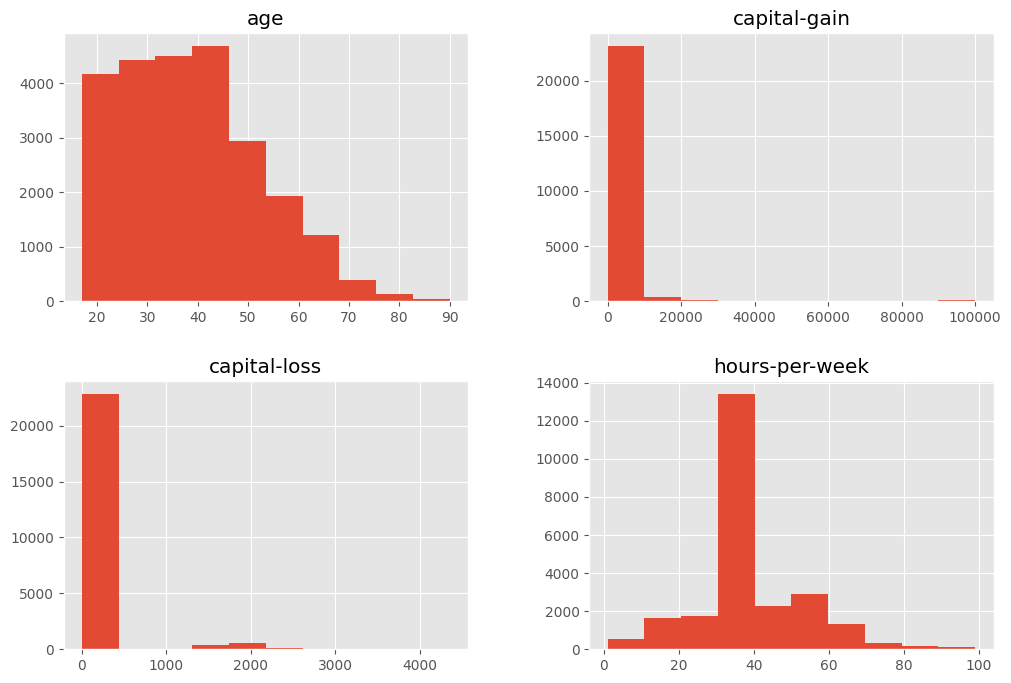

In [12]:
X_train.hist(figsize=(12,8))
experiment.log_figure('X_train_numeric_distr', plt);

Что мы можем увидеть из результатов?
* Числовых переменных в исходных данных только 4;
* Возраст пользователя варьируется в диапазоне от 17 до 90 лет и в среднем составляет 39 лет;
* Видим пропуски в признаках capital-gain и capital-loss (значение count меньше размера данных). По гистограмме можно заметить, что большое количество значений в этих признаках - это просто нули;

## Предобработка данных

### Проверка на наличие пропусков и типов переменных



In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24420 non-null  int64  
 1   workclass       23223 non-null  object 
 2   education       23443 non-null  object 
 3   marital-status  24420 non-null  object 
 4   occupation      24420 non-null  object 
 5   relationship    24420 non-null  object 
 6   race            24420 non-null  object 
 7   sex             24420 non-null  object 
 8   capital-gain    23705 non-null  float64
 9   capital-loss    23936 non-null  float64
 10  hours-per-week  24420 non-null  int64  
 11  native-country  24420 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 2.2+ MB


Типы в наших данных:
* 8 признаков типа **object** - обычно это строковые значения;
* 3 признака типа **int64** - целочисленные значения;
* 2 признака типа **float64** - числа с плавающей запятой. 

Кроме этого, мы видим, что признаки *workclass, education, capital-gain и capital-loss* имеют пропуски в данных.

### Обработка пропусков в данных

Далеко не все алгоритмы умеют работать с пропусками в данных. Кроме этого, удачно заполнив пропуски, мы сможем лучше восстановить распределение данных, а значит лучше построить моделей. 

Самые популярные методы для обработки пропусков:
- Удаление значений с пропусками (не желательно при большом количестве пропусков, потому что теряются данные);
- Заполнение средним/медианным значением;
- Заполненние самым частым значением;
- Заполнение случайным значением.

**Важно:** тестовую выборку мы всегда обрабатываем также, как и обучающую выборку. 

In [14]:
X_train['capital-loss'] = X_train['capital-loss'].fillna(0)
X_train['capital-gain'] = X_train['capital-gain'].fillna(0)

Сделаем то же самое для тестовой выборки:

In [15]:
X_test['capital-loss'] = X_test['capital-loss'].fillna(0)
X_test['capital-gain'] = X_test['capital-gain'].fillna(0)

Посмотрим наиболее частое значение признака в столбцах **workclass** и **education**:

In [16]:
X_train['workclass'].value_counts(True).head(1)

workclass
Private    0.696766
Name: proportion, dtype: float64

In [17]:
X_train['education'].value_counts(True).head(1)

education
HS-grad    0.322484
Name: proportion, dtype: float64

Наиболее частое значение признака **workclass** - Private, признака **education** - HS-grad. 

Теперь явно заполним пропуски:

In [18]:
X_train['workclass'] = X_train['workclass'].fillna('Private')
X_train['education'] = X_train['education'].fillna('HS-grad')

Сделаем то же самое для тестовой выборки:

In [19]:
X_test['workclass'] = X_test['workclass'].fillna('Private')
X_test['education'] = X_test['education'].fillna('HS-grad')

### Кодировка категориальных переменных

В данных 8 столбцов являются категориальными признаками. При чём в нашей задаче эти признаки **текстовые**. Машине сложно обрабатывать текстовые признаки, поэтому нам необходимо закодировать их, то есть преобразовать в числовые. 

Для начала необходимо выделить категориальные признаки:

In [20]:
categorical_features = ['workclass', 'education', 'marital-status', 
                        'occupation', 'relationship', 'race', 'sex', 
                        'native-country']

non_categorical_features = ['age', 'capital-gain', 'capital-loss', 
                            'hours-per-week']

Посмотрим на столбцы категориальных переменных:

In [21]:
X_train[categorical_features].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
2,Private,11th,Married-civ-spouse,Other-service,Husband,Black,Male,United-States
3,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,United-States
4,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,United-States


Мы рассмотрим два популярных метода кодирования категориальных признаков:
* Label Encoding, которому соответствует класс `LabelEncoder()` из библиотеки **sklearn**
* One Hot Encoding, которому соответствует класс `OneHotEncoder()` из библиотеки **sklearn**

**Label Encoding**



In [22]:
# создаём предварительную копию
X_train_le = X_train.copy()
X_test_le = X_test.copy()

In [23]:
# создаём объект класса LabelEncoder
label_encoder = preprocessing.LabelEncoder()

# кодируем признаки с помощью LabelEncoder
for feature in categorical_features:
    X_train_le[feature] = label_encoder.fit_transform(X_train_le[feature])
    X_test_le[feature] = label_encoder.transform(X_test_le[feature])

In [24]:
# проверяем результат
X_train_le.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,4,11,2,3,0,4,1,0.0,0.0,40,39
1,27,4,11,2,7,0,4,1,0.0,0.0,45,39
2,44,4,1,2,8,0,2,1,0.0,0.0,60,39
3,59,4,9,5,1,4,4,1,0.0,0.0,60,39
4,54,4,9,0,12,1,4,0,0.0,1408.0,38,39


In [25]:
# проверяем результат
X_test_le.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,27,4,15,0,1,1,4,0,0.0,0.0,38,39
1,45,7,11,2,4,5,4,0,0.0,0.0,40,39
2,29,4,9,2,4,0,2,1,0.0,0.0,55,39
3,30,4,9,4,7,1,4,0,0.0,0.0,40,39
4,29,6,15,0,3,1,4,1,2202.0,0.0,50,39


**One Hot Encoding**



In [26]:
# создаём объект класса OneHotEncoder
onehot_encoder = preprocessing.OneHotEncoder()

In [27]:
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
X_train_onehot = onehot_encoder.fit_transform(X_train[categorical_features]).toarray()

# применяем полученное преобразование к тестовой выборке, результат переводим в массив
X_test_onehot = onehot_encoder.transform(X_test[categorical_features]).toarray()

# запишем полученные названия новых колонок в отдельную переменную
columns = onehot_encoder.get_feature_names_out(categorical_features)

In [28]:
# сформируем датафреймы из закодированных данных
X_train_onehot = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot = pd.DataFrame(X_test_onehot, columns=columns)

И наконец, запишем в новую переменную полученный результат, удалив все незакодированные категориальные признаки из новой таблицы. 

In [29]:
# соединяем новую табличку с исходной
X_train_new = pd.concat([X_train, X_train_onehot], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot], axis=1)

# удаляем старые категориальные признаки
X_train_new = X_train_new.drop(columns=categorical_features)
X_test_new = X_test_new.drop(columns=categorical_features)

In [30]:
# смотрим результат
X_train_new.head()

,age,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,49,0.0,0.0,40,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,27,0.0,0.0,45,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,44,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,59,0.0,0.0,60,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,54,0.0,1408.0,38,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Обучение модели 

## Выбор метода обучения классификатора

Для обучения классификатора воспользуемся логистической регрессией. Создаем прототип класса модели:

In [31]:
linear_model_le = linear_model.LogisticRegression(random_state = 42, solver = 'liblinear')
linear_model_oh = linear_model.LogisticRegression(random_state = 42, solver = 'liblinear')
experiment.log_parameters({'random_state' : '42', 'solver' : 'liblinear'})

## Обучение модели на разных типах закодированных данных

In [32]:
linear_model_oh.fit(X_train_new, y_train);

In [33]:
linear_model_le.fit(X_train_le, y_train);

# Валидация модели на тестовой выборке

In [34]:
# строим предсказания не тестовых выборках
prediction_oh = linear_model_oh.predict(X_test_new)
prediction_le = linear_model_le.predict(X_test_le)

In [35]:
# проверяем значения классов
np.unique(prediction_oh)

array([0, 1], dtype=int64)

In [36]:
# проверяем значения классов
np.unique(prediction_le)

array([0, 1], dtype=int64)

In [37]:
## Сколько 1го класса присутствует в предсказаниях?
# для LE
prediction_le = pd.DataFrame(prediction_le)
prediction_le.value_counts()

0    7236
1     905
Name: count, dtype: int64

In [38]:
# для OneHot
prediction_oh = pd.DataFrame(prediction_oh)
prediction_oh.value_counts()

0    6596
1    1545
Name: count, dtype: int64

In [39]:
# Сколько 1го класса присутствует в y_test?
y_test.value_counts()

income
0    6214
1    1927
Name: count, dtype: int64

## Точность предсказания

Посчитаем точность (**accuracy**) работы моделей. Напомним, что точность отражает, сколько в процентном соотношении от размера тестовой выборки модель угадала 1 и сколько угадала 0.

Функция для подсчета точности реализована в библиотеке **sklearn** и называется `accuracy_score()`.

In [40]:
# расчёт метрики 'accuracy'
acc_oh = metrics.accuracy_score(y_test, prediction_oh)
acc_le = metrics.accuracy_score(y_test, prediction_le)

In [41]:
# логируем accuracy для OneHot
experiment.log_metric('Accuracy OneHot data', acc_oh)

In [42]:
# логируем accuracy для LE
experiment.log_metric('Accuracy LabelEncoding data', acc_le)

Сравним значения точности для наших моделей с точностью для константного классификатора, модели, которая всегда бы предсказывала больший класс, в нашем случае 0. Для этого можно в функцию `accuracy_score()` в качестве второго аргумента передать массив нулей такого же размера. Это делается с помощью функции `zeros_like()` из библиотеки **numpy**.

In [43]:
print(f'Accuracy Major Class: {metrics.accuracy_score(y_test, np.zeros_like(y_test)).round(3)}')

Accuracy Major Class: 0.763


In [44]:
print(f'Accuracy LabelEncoding data = {acc_le:.3f}')

Accuracy LabelEncoding data = 0.803


In [45]:
print(f'Accuracy OneHotEncoder data = {acc_oh:.3f}')

Accuracy OneHotEncoder data = 0.857


## Таблица сопряженности модели классификации

Другой способ оценивать качество работы классификатора - использовать таблицу сопряженности. 


|                   |  Предсказано `0` |  Предсказано `1` |
|:-------------------|:------------------|:------------------|
|**Фактически** `0`  |       TN         |       FP         |
|**Фактически** `1`  |       FN         |       TP         | 


In [46]:
# матрица сопряженности для OneHot
pd.DataFrame(metrics.confusion_matrix(y_test, prediction_oh))

,0,1
0,5822,392
1,774,1153


In [47]:
# матрица сопряженности для LE
pd.DataFrame(metrics.confusion_matrix(y_test, prediction_le))

,0,1
0,5922,292
1,1314,613


In [48]:
# логирование матриц сопряженности
experiment.log_confusion_matrix(y_test, prediction_oh);
experiment.log_confusion_matrix(y_test, prediction_le);

## Прогноз вероятности принадлежности к классу

In [49]:
# расчёт вероятностей классов на тестовых выборках
pred_proba_oh = linear_model_oh.predict_proba(X_test_new)
pred_proba_le = linear_model_le.predict_proba(X_test_le)

In [50]:
# Как выглядят предсказания?
print(f'pred_proba_oh \n{pred_proba_oh},\n\n pred_proba_le \n{pred_proba_le}')

pred_proba_oh 
[[0.96976696 0.03023304]
 [0.46889363 0.53110637]
 [0.31858519 0.68141481]
 ...
 [0.99606758 0.00393242]
 [0.39208478 0.60791522]
 [0.82445578 0.17554422]],

 pred_proba_le 
[[0.86886781 0.13113219]
 [0.92394727 0.07605273]
 [0.78535777 0.21464223]
 ...
 [0.97229339 0.02770661]
 [0.65963447 0.34036553]
 [0.57478171 0.42521829]]


In [51]:
# интересует только вероятность класса 1
pred_proba_oh1 = pred_proba_oh[:, 1]
pred_proba_le1 = pred_proba_le[:, 1]

Посмотрим на распределение предсказанной классификатором вероятности дохода > 50к, метки `1`.

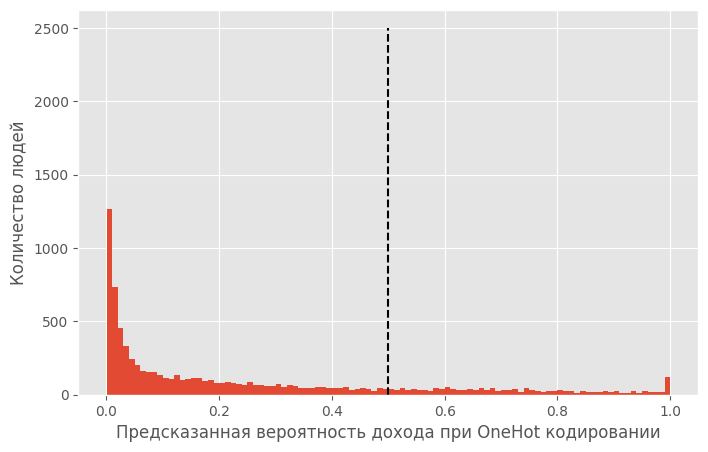

In [52]:
plt.figure(figsize=(8, 5))

plt.hist(pred_proba_oh1, bins=100)
plt.vlines(0.5, 0, 2500, color='black', linestyle='--')

plt.xlabel('Предсказанная вероятность дохода при OneHot кодировании')
plt.ylabel('Количество людей')

experiment.log_figure('predicted_income_probability_oh', plt);

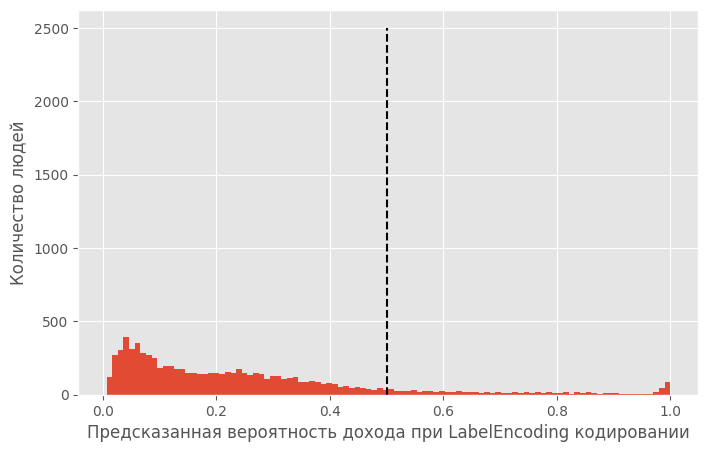

In [53]:
plt.figure(figsize=(8, 5))

plt.hist(pred_proba_le1, bins=100)
plt.vlines(0.5, 0, 2500, color='black', linestyle='--')

plt.xlabel('Предсказанная вероятность дохода при LabelEncoding кодировании')
plt.ylabel('Количество людей')

experiment.log_figure('predicted_income_probability_le', plt);

## ROC кривая классификатора

Если хотят сравнить метрики на разных наборах данных, обычно работают не с абсолютными значениями True Positive и False Positive, а с их долями:

* Доля ложноположительных срабатываний $\text{FPR} = \frac{FP}{FP + TN}$;
* Доля истинно положительных срабатываний $\text{TPR} = \frac{TP}{TP + FN}$.

Заметим, что $FP + TN$ дает общее число объектов класса $0$, а $TP + FN$ - общее число объектов класса $1$. 

Одной из самых популярных метрик для задачи классификации является ROC кривая. ROC расшифровывается как *Receiver Operating Characteristic*. Эта кривая наглядно показывает зависимость доли истинно позитивных срабатываний (**TPR**) от доли ложно позитивных срабатываний (**FPR**) при изменении порога классификации.

Функция `roc_curve()` из **scikit-learn** позволяет получить координаты точек ROC кривой, а также значения порога `threshold`, при котором достигается соответствующие значения метрик **FPR** и **TPR**.

На вход функции `roc_curve()` необходимо передать два аргумента:
* истинные значения меток
* вероятности, предсказанные моделью

In [54]:
false_positive_rates_oh, true_positive_rates_oh, threshold_oh = metrics.roc_curve(y_test, pred_proba_oh1)
false_positive_rates_le, true_positive_rates_le, threshold_le = metrics.roc_curve(y_test, pred_proba_le1)

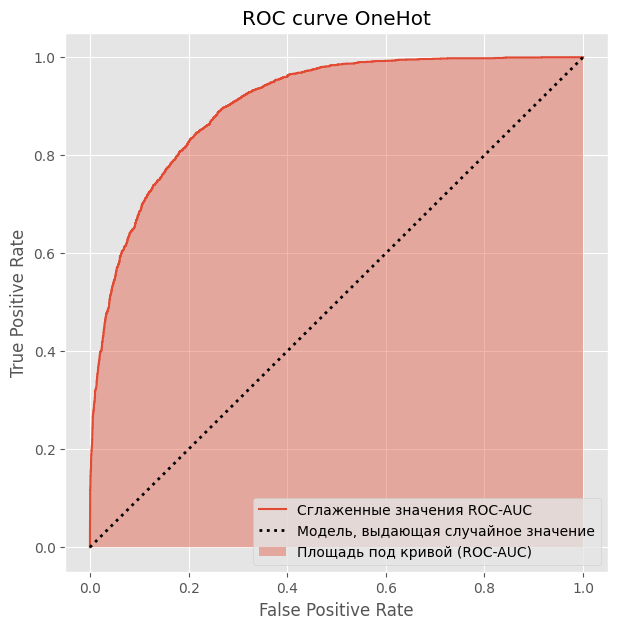

In [55]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates_oh, true_positive_rates_oh, 
    label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
    label='Модель, выдающая случайное значение')

plt.title('ROC curve OneHot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates_oh, true_positive_rates_oh, step="pre", 
    alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show();

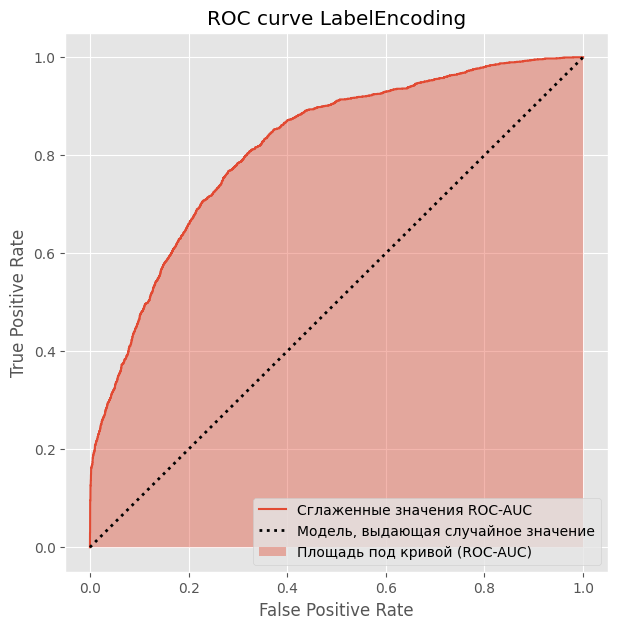

In [56]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates_le, true_positive_rates_le, 
    label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
    label='Модель, выдающая случайное значение')

plt.title('ROC curve LabelEncoding')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates_le, true_positive_rates_le, step="pre", 
    alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show();

In [57]:
# расчёт площади под кривыми ROC
roc_auc_oh = metrics.roc_auc_score(y_test, pred_proba_oh1).round(3)
roc_auc_le = metrics.roc_auc_score(y_test, pred_proba_le1).round(3)

In [58]:
print(f'ROC-AUC на тестовой выборке OneHotEncoding: {metrics.roc_auc_score(y_test, pred_proba_oh1).round(3)}')
print(f'ROC-AUC на тестовой выборке LabelEncoding: {metrics.roc_auc_score(y_test, pred_proba_le1).round(3)}')

ROC-AUC на тестовой выборке OneHotEncoding: 0.904
ROC-AUC на тестовой выборке LabelEncoding: 0.815


In [59]:
# логирование метрик ROC-AUC
experiment.log_metric('roc_auc OneHot data', roc_auc_oh)
experiment.log_metric('roc_auc LabelEncoding data', roc_auc_le)

In [60]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/best1ll/predict-income/1c74f94bb44a43989e943634d12c4def
COMET INFO:   Metrics:
COMET INFO:     Accuracy LabelEncoding data : 0.8027269377226385
COMET INFO:     Accuracy OneHot data        : 0.8567743520452032
COMET INFO:     roc_auc LabelEncoding data  : 0.815
COMET INFO:     roc_auc OneHot data         : 0.904
COMET INFO:   Parameters:
COMET INFO:     C                 : 1.0
COMET INFO:     categories        : auto
COMET INFO:     class_weight      : 1
COMET INFO:     drop              : 1
COMET INFO:     dtype             : <class 'numpy.float64'>
COMET INFO:     dual              : False
COMET INFO:     fit_intercept     : Tr